# DProvDB Experimental Evaluation on EQW (BFS) Task

We would like to understand DProvDB's performance via empirical study.

## End-to-end Comparison

First we would like to perform an end-to-end comparison of DProvDB against baseline systems.

We have the following baselines:

- DProvDB minus additiveGM (Vanilla mechanism in our paper)
- Chorus
- DProvDB minus cached views (i.e., enabling Chorus with Provenance table)
- Simulating PrivateSQL 

Note that the key idea in PrivateSQL is to generate synopses for pre-determined views and answer queries using synopses.
The overall privacy budget is split to generate the synopses in advance.
One prominent way to allocate budget to views, as mentioned in PrivateSQL paper, is fair allocation.
That is to split the budget w.r.t the sensitivity of the views s.t. the expected error on each view is the same.
Since PrivateSQL system is not open source, we use our system with a specific setting (DProvDB minus additiveGM, with predetermined view constraints) to simulate PrivateSQL.

Each experiment is run for 4 times, we plot the mean and the variance as evaluation results.

In [1]:
# load package and fonts

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(font="Helvetica", rc={"figure.figsize":(4, 3)})
sns.set_theme(style="white")
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 1.75})

1) RRQ, over Adult dataset

In [2]:
# load data

report = pd.read_csv('../data/EQW_adult_end_to_end.csv', sep=';')

report = report.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
report.columns = report.columns.str.strip()


# processing list strings

def parse_list(s):
    if isinstance(s, str) and s.startswith('List'):
        return [float(x) for x in s[5: -1].split(",")]
    else:
        return s

report = report.applymap(parse_list)

report.loc[(report["viewConstraintFlag"] == "static fixed: 1.0") & (report["mechanism"] == "baseline"), "mechanism"] = "PrivateSQL"
report.loc[(report["viewConstraintFlag"] == "static fixed: 1.0") & (report["mechanism"] == "PrivateSQL"), "viewConstraintFlag"] = "dynamic fixed: 1.0"

report.head(5)

,dataset,mechanism,task,viewConstraintFlag,budget,utility,totalNoOfQueries,analystConstraints,setup_time,execution_time,utility_breakdown,DCFG,accountant,accountant_breakdown,view_breakdown,avgAccuracy,runIndex,randomness
0,adult,aGM,EQW_BFS,dynamic fixed-aGM: 1.0,200.0,302,624,"[50.0, 200.0]",6457.151545,2099.767811,"[151.0, 151.0]",620.048842,"[0.016343407332897186, 0.024144630879163742, 0...","[0.028173066675662994, 0.0]","[0.028173066675662994, 0.0, 0.0, 0.0, 0.0, 0.0...",16989.403974,1,1025
1,adult,baseline,EQW_BFS,dynamic fixed-normalized: 1.0,200.0,297,624,"[40.0, 160.0]",4554.848840,1111.134595,"[151.0, 146.0]",604.517423,"[0.0163433700799942, 0.08097603917121887, 0.08...","[0.040488019585609436, 0.040488019585609436]","[0.08097603917121887, 0.0, 0.0, 0.0, 0.0, 0.0,...",16886.531987,1,1025
2,adult,Chorus,EQW_BFS,dynamic fixed-normalized: 1.0,200.0,212,624,"[40.0, 160.0]",4187.286087,3471.349251,"[111.0, 101.0]",424.734656,"[0.016343407332897186, 0.08097607642412186, 0....","[2.4644972756505013, 2.163473889231682]","[4.627971164882183, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",15539.150943,1,1025
3,adult,ChorusP,EQW_BFS,dynamic fixed-normalized: 1.0,200.0,212,624,"[40.0, 160.0]",3856.622623,3403.977242,"[111.0, 101.0]",424.734656,"[0.0163433700799942, 0.08097603917121887, 0.16...","[2.464495822787285, 2.1634724736213684]","[4.627968296408653, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",15539.150943,1,1025
4,adult,aGM,EQW_BFS,dynamic fixed-aGM: 1.0,200.0,312,624,"[50.0, 200.0]",3737.045402,1411.975922,"[156.0, 156.0]",640.580260,"[0.016343407332897186, 0.024144630879163742, 0...","[0.028173066675662994, 0.0]","[0.028173066675662994, 0.0, 0.0, 0.0, 0.0, 0.0...",17150.000000,2,2050


In [3]:
# load data for tpc-h

report_tpc = pd.read_csv('../data/EQW_tpch_end_to_end.csv', sep=';')

report_tpc = report_tpc.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
report_tpc.columns = report_tpc.columns.str.strip()


report_tpc = report_tpc.applymap(parse_list)

report_tpc.loc[(report_tpc["viewConstraintFlag"] == "static fixed: 1.0") & (report_tpc["mechanism"] == "baseline"), "mechanism"] = "PrivateSQL"
report_tpc.loc[(report_tpc["viewConstraintFlag"] == "static fixed: 1.0") & (report_tpc["mechanism"] == "PrivateSQL"), "viewConstraintFlag"] = "dynamic fixed: 1.0"

report_tpc.head(5)

,dataset,mechanism,task,viewConstraintFlag,budget,utility,totalNoOfQueries,analystConstraints,setup_time,execution_time,utility_breakdown,DCFG,accountant,accountant_breakdown,view_breakdown,avgAccuracy,runIndex,randomness
0,tpch,aGM,EQW_BFS,dynamic fixed-aGM: 1.0,200.0,86,172,"[50.0, 200.0]",26752.240291,672.567516,"[43.0, 43.0]",176.570200,"[0.016343407332897186, 0.016343407332897186, 0...","[0.01812884584069252, 0.0]","[0.0, 0.0, 0.0, 0.01812884584069252, 0.0]",22800.000000,1,1025
1,tpch,baseline,EQW_BFS,dynamic fixed-normalized: 1.0,200.0,86,172,"[40.0, 160.0]",24739.492232,376.401880,"[43.0, 43.0]",176.570200,"[0.0163433700799942, 0.0326867401599884, 0.050...","[0.034184008836746216, 0.034184008836746216]","[0.0, 0.0, 0.0, 0.06836801767349243, 0.0]",22800.000000,1,1025
2,tpch,Chorus,EQW_BFS,dynamic fixed-normalized: 1.0,200.0,62,172,"[40.0, 160.0]",24676.352511,8982.723258,"[31.0, 31.0]",127.294795,"[0.016343407332897186, 0.03268681466579437, 0....","[0.5395907908678055, 0.5395907908678055]","[0.0, 0.0, 0.0, 1.079181581735611, 0.0]",22296.774194,1,1025
3,tpch,ChorusP,EQW_BFS,dynamic fixed-normalized: 1.0,200.0,62,172,"[40.0, 160.0]",24732.440517,8890.197547,"[31.0, 31.0]",127.294795,"[0.0163433700799942, 0.0326867401599884, 0.050...","[0.5395905673503876, 0.5395905673503876]","[0.0, 0.0, 0.0, 1.0791811347007751, 0.0]",22296.774194,1,1025
4,tpch,aGM,EQW_BFS,dynamic fixed-aGM: 1.0,200.0,86,172,"[50.0, 200.0]",24584.141867,417.409416,"[43.0, 43.0]",176.570200,"[0.016343407332897186, 0.016343407332897186, 0...","[0.01812884584069252, 0.0]","[0.0, 0.0, 0.0, 0.01812884584069252, 0.0]",22800.000000,2,2050


In [4]:
# processing data

mechanism_mapping = {"aGM": "DProvDB", "baseline": "Vanilla", "Chorus": "Chorus", "ChorusP": "ChorusP"}

def processing_data_EQW(df, dataset, task="EQW_BFS", sample_freq = 12, mech_dt = ["aGM", "baseline", "Chorus", "ChorusP"]):
    
    filtered_df = df[(df["dataset"]==dataset) & (df["task"]==task)]
            
    ret_dt = {}

    for mech in mech_dt:
        sample_num = len(list(filtered_df[filtered_df['mechanism']==mech]['accountant'].values)[0])//sample_freq
    
        for i in range(sample_num):
            workload_index = i * int(filtered_df['totalNoOfQueries'].values[0]) / sample_num          
            ret_dt[(mechanism_mapping[mech], workload_index)] = [ l[i*sample_freq] for l in list(filtered_df[filtered_df['mechanism']==mech]['accountant'].values)]

    return ret_dt


# test
dt = processing_data_EQW(report_tpc, "tpch", "EQW_BFS")
# print(dt)


/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


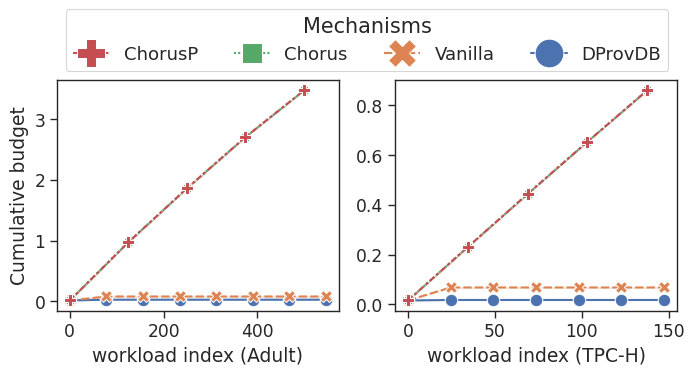

In [5]:
# plotting

# get data
dt = processing_data_EQW(report, "adult", "EQW_BFS")

dt_tpc = processing_data_EQW(report_tpc, "tpch", "EQW_BFS")



sns.set(font="Helvetica", rc={"figure.figsize":(4, 3)})
sns.set_theme(style="white")
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.4, rc={"lines.linewidth": 1.75})

# drawing figures
fig, axes = plt.subplots(ncols=2,figsize=(8, 3))

data = pd.Series(dt).reset_index()
data.columns = ['mechanisms', 'workload_index', 'budget']
data = data.explode("budget")
line = sns.lineplot(data=data, x='workload_index', y='budget', hue='mechanisms', ax=axes[0], linewidth=1.5, style="mechanisms", markers=True, markersize=9, dashes=True)
handles, labels = axes[0].get_legend_handles_labels()

sns.move_legend(axes[0], "lower center", bbox_to_anchor=(1.1, 1), ncol=4, title="Mechanisms", frameon=True,handles=handles[::-1], markerscale=2.3, fontsize=13, title_fontsize=15)
line.set(ylabel="Cumulative budget")
line.set(xlabel="workload index (Adult)")

# cur_indices = line.get_xticklabels()
# new_xticks = [int(i.get_text()) *12 for i in cur_indices[1:]]
# print(new_xticks)
# line.set_xticklabels(new_xticks)



data = pd.Series(dt_tpc).reset_index()
data.columns = ['mechanisms', 'workload_index', 'budget']
data = data.explode("budget")
line = sns.lineplot(data=data, x='workload_index', y='budget', hue='mechanisms', legend=False, ax=axes[1], linewidth=1.5, style="mechanisms", markers=True, markersize=9, dashes=True)
handles, labels = axes[0].get_legend_handles_labels()
axes[1].set(xlabel="workload index (TPC-H)")
axes[1].set(ylabel=None)


plt.savefig('end_to_end_EQW.pdf', dpi=600, bbox_inches='tight')



In [6]:
# generate performance table
import numpy as np

def process_for_runtime(df):
    ret = []
    mech_dt = ["aGM", "baseline", "PrivateSQL", "Chorus", "ChorusP"]
    for mech in mech_dt:
        filtered_df = df[df["mechanism"]==mech]
        if mech in ["aGM", "baseline", "PrivateSQL"]:
            ret.append(np.mean(filtered_df["setup_time"]))
        ret.append(np.mean(filtered_df["execution_time"]))
        ret.append(np.mean(filtered_df["utility"]))
        ret.append(np.mean(filtered_df["execution_time"]) / np.mean(filtered_df["utility"]))
    return ret


In [7]:
fill_in = process_for_runtime(report)
print(fill_in)

latex_tab = """\\begin{{tabular}}{{ccccc}}
    \\toprule \hline
    Systems  & Setup Time   & Running Time & No. of Queries & Per Query Perf  \\\ \hline
    \oursystem     &  {:.2f} ms    &  {:.2f} ms  & {:.1f}  & {:.2f} ms \\\ 
    Vanilla &  {:.2f} ms    & {:.2f} ms  & {:.1f}   & {:.2f} ms  \\\ 
    sPrivateSQL &  {:.2f} ms &  {:.2f} ms & {:.1f} & {:.2f} ms \\\ 
    Chorus &  N/A   &  {:.2f} ms  & {:.1f}   & {:.2f} ms \\\ 
    ChorusP & N/A   &  {:.2f} ms  & {:.1f}  & {:.2f} ms \\\ \hline
    \\bottomrule
\end{{tabular}}""".format(fill_in[0], fill_in[1], fill_in[2], fill_in[3], fill_in[4], fill_in[5], fill_in[6], 
                        fill_in[7], fill_in[8], fill_in[9], fill_in[10], fill_in[11], fill_in[12], fill_in[13], 
                        fill_in[14], fill_in[15], fill_in[16], fill_in[17])
    
print(latex_tab)

[4310.1268285, 1528.5248335, 304.5, 5.019785988505747, 3814.4641180000003, 1045.6939874999998, 294.5, 3.550743590831918, nan, nan, nan, nan, 3234.1134315, 212.0, 15.255252035377358, 3197.43968475, 212.0, 15.082262663915095]
\begin{tabular}{ccccc}
    \toprule \hline
    Systems  & Setup Time   & Running Time & No. of Queries & Per Query Perf  \\ \hline
    \oursystem     &  4310.13 ms    &  1528.52 ms  & 304.5  & 5.02 ms \\ 
    Vanilla &  3814.46 ms    & 1045.69 ms  & 294.5   & 3.55 ms  \\ 
    sPrivateSQL &  nan ms &  nan ms & nan & nan ms \\ 
    Chorus &  N/A   &  3234.11 ms  & 212.0   & 15.26 ms \\ 
    ChorusP & N/A   &  3197.44 ms  & 212.0  & 15.08 ms \\ \hline
    \bottomrule
\end{tabular}
